# A walkthrough of Surrogate-Assisted Multi-Objective Optimisation (SAMOO)

Now that we know how to assess non-dominance of uncertain objective positions due to emulation errors, we can now effectively use surrogate models without compromising the reliability of solutions.

For this tutorial, we will still be using the modified Kursawe problem. We need some directories generated in Part 2, so if you have not done so, finish Part 2 and come back here later.

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import laGPy as gpr

In [2]:
def kursawe_2d(x):
    x = np.array(x)
    obj1 = -10 * np.exp(-0.2 * np.sqrt(x[0]**2 + x[1]**2))
    obj2 = np.abs(x[0])**0.8 + 5 * np.sin(x[0]**3) + np.abs(x[1])**0.8 + 5 * np.sin(x[1]**3)
    return obj1, obj2

def emulate_obj(Xref, X, Z1, Z2):
    obj1 = gpr.laGP(Xref=Xref, X=X, Z=Z1, start = 6, end = 10, verb=0)
    obj2 = gpr.laGP(Xref=Xref, X=X, Z=Z2, start = 6, end = 10, verb=0)
    return obj1, obj2

n_samples = 100
x1_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x2_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([kursawe_2d([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

As this benchmark is not too complex, it doesn't take much time to complete one iteration and it doesn't take a lot of iteration to obtain a set of Pareto optimal solutions (if you haven't done so yet, finish Part 2 first). However, in reality, real-world models do not run this fast. Even with parallelisation, it can take a few hundred, even thousand iterations until the swarm converges to the Pareto front. If important timely decisions rely on the outcome of such optimisation process, we would need some help to speed up this process. 

Let's pretend for a while that the Kursawe problem is a complex model that is expensive to evaluate. There's nothing we could do about the run time of the complex model. What we can do though is to employ an "emulator", a faster and cheaper model that approximates the relationships between the known (i.e., previously evaluated) input and outputs of the complex model in order to predict its response to some input values that were not previously evaluated. This emulator is also known as the surrogate model. Because the surrogate model is an approximation, its prediction has errors. These errors could mislead the decision-making to some suboptimal solutions that are not actually in the Pareto front. This is some price to pay for speeding up the process, but don't worry as we have means to manage these uncertainties and still obtain truly Pareto optimal solutions.

There are many surrogate models available in literature. However, we will use Gaussian Process Regression (GPR) as it provides a convenient way to take into account the uncertainty in predictions of the surrogate model, which, as previously said, needs to be managed well.

Surrogate-Assisted Multi-Objective Optimisation (SAMOO) follows this general algorithm:
1. LHS sampling of initial training dataset and starting population
2. Complex model evaluation (hereinafter referred to as Outer Iteration)
3. Pareto dominance evaluation
     - if front converged: exit; else: continue to step 4
4. (Re)training the GPR
5. MOO with GPR replacing the complex model (hereinafter referred to as Inner Iterations)
6. Resampling for new training points (also called infills)

Steps 2-6 are performed iteratively until convergence is achieved in Step 3. 

To facilitate this entire process, we will use samoo_utils.py. Let us first prepare our PEST files (control, template, instruction files) to be SAMOO-ready. Let's create a new directory where we will put all our SAMOO-related files and generate an initial training dataset for the surrogate model using Latin hypercube sampling.


In [3]:
base_d = "./demo_files/kursawe2d"
assert os.path.exists(base_d)
temp_d = "kursawe2d_demo"

if os.path.exists(os.path.join(temp_d, 'samoo_runs')):
    shutil.rmtree(os.path.join(temp_d, 'samoo_runs'))
os.makedirs(os.path.join(temp_d, 'samoo_runs'))
shutil.copytree(os.path.join(temp_d, 'kursawe2d_samoo_template'), os.path.join(temp_d, 'samoo_runs', 'template'))

sys.path.insert(0,temp_d)
from bin.samoo_utils import SAMOO
optimizer = SAMOO() #load the utility and its default values for now. We modify some args below
optimizer.nmax_inner = 20 #the number of inner iterations
optimizer.ppd_beta = 0.6 #discussed in Part 2

swarm_size = 40
bounds = np.array([[-5, 5] for i in range(2)])
from bin.LHS_sampler import generate_lhstrainingset
generate_lhstrainingset(os.path.join(temp_d, 'samoo_runs', 'template'), seed=42, n_samples=swarm_size, n_dimensions=2, bounds=bounds)

sys.path.remove(temp_d)

Let's prepare all template files needed. We will generate three sets of template files:
1. template_outer -- for the outer iteration
2. template_inner -- for the inner iteration
3. template_repo_update -- for updating the outer iteration repository

In [4]:
os.chdir(os.path.join('kursawe2d_demo', 'samoo_runs'))
optimizer.prep_templates()


2025-05-16 13:58:17.971722: prepping templates 


2025-05-16 13:58:17.972721: prepping outer template 

noptmax:-1, npar_adj:2, nnz_obs:4

2025-05-16 13:58:18.097115: outer template prepped 


2025-05-16 13:58:18.097115: prepping repo update template 

noptmax:-1, npar_adj:2, nnz_obs:4

2025-05-16 13:58:18.231750: outer repo update template prepped 


2025-05-16 13:58:18.231750: prepping inner template 

noptmax:20, npar_adj:2, nnz_obs:4

2025-05-16 13:58:18.338920: inner template prepped 



Then, run a sweep of the initial training dataset through the complex model to get the deterministic output with which to train the GPR with.  Result of this will be saved in the directory "Outer_0". This is Step 2-3 of the algorithm.

In [5]:
optimizer.exe_file = '../../../bin/pestpp-mou'
optimizer.outer_sweep(0)

['outer_0']

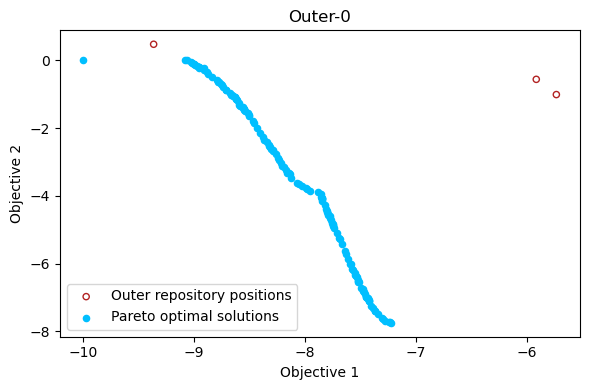

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outer-0'}, xlabel='Objective 1', ylabel='Objective 2'>,
     generation             member     obj1      obj2  nsga2_front  \
 7            0   gen=0_training=7 -9.36162  0.474329            1   
 8            0   gen=0_training=8 -5.91507 -0.560988            1   
 11           0  gen=0_training=11 -5.73416 -1.010610            1   
 
     nsga2_crowding_distance  spea2_unconstrained_fitness  \
 7              1.000000e+30                      111.157   
 8              2.000000e+00                      106.179   
 11             1.000000e+30                      109.169   
 
     spea2_constrained_fitness  is_feasible  feasible_distance  
 7                     111.157            1               -999  
 8                     106.179            1               -999  
 11                    109.169            1               -999  )

In [6]:
true_pareto = pd.read_csv(os.path.join('..', 'kursawe2d_solution_obj.csv'))

def plot_outer(outer_dir, fig=None, ax=None, show=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if outer_dir.endswith('_0'):
        outer_pareto = pd.read_csv(os.path.join(outer_dir, 'kur.pareto.summary.csv'))
    else:
        outer_pareto = pd.read_csv(os.path.join(outer_dir, 'outer_repo', 'outer_repo.pareto.summary.csv'))
    
    outer_pareto = outer_pareto.loc[outer_pareto['nsga2_front'] == 1]
    
    ax.scatter(outer_pareto['obj1'], outer_pareto['obj2'], c='none', ec='firebrick', s=20, zorder=10, label='Outer repository positions')
    ax.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=20, label='Pareto optimal solutions')
    
    ax.set_xlabel('Objective 1')
    ax.set_ylabel('Objective 2')
    ax.legend()
    
    ax.set_title(f'Outer-{outer_dir.split("_")[1]}')
    if show and fig is not None:
        plt.tight_layout()
        plt.show()
    
    return fig, ax, outer_pareto

plot_outer('outer_0')


Outer-0 produced some non-dominated positions. They are still far from the true Pareto optimal solutions.

The input-output pair resulting from such sweep will be used as training dataset to retrain the GPR, which will be needed in the inner iterations. This GPR will be called in the inner iterations instead of the complex model.

Let's prepare the GPR training files (Step 4) and proceed with the first inner iteration (Step 5), the output of which will be saved in "Inner_1" directory. We will do 20 inner iterations for now.

In [7]:
inner_dirs, outer_dirs = optimizer.get_dirlist()
optimizer.inner_prep(inner_dirs, outer_dirs) #this will write the training dataset
next_inner_index = 1 if len(inner_dirs) == 0 else int(inner_dirs[-1].split("_")[1]) + 1
optimizer.inner_opt(next_inner_index) #this executes pestpp-mou that calls on the GPR in the inner iterations

['inner_1']

At this stage the GPR only has very limited knowledge informed only by a sample of 40 points from the decision space and their corresponding deterministic objective function values. Thus, we recognize that GPR emulations are incorrect and these errors should be taken into consideration when evaluating dominance relationships in the inner iterations. As discussed in Part 2, SAMOO deals with these uncertainties through PPD. The basic idea of PPD is that we cannot rule out dominated members to be completely suboptimal, likewise, we cannot trust that non-dominated members are truly Pareto optimal. Thus, if the dominance relationships does not reach our confidence threshold (passed through the ppd_beta argument in the pestpp-mou control file), we can just keep both solution in the 'surrogate repository' for now. As a result, we won't have a Pareto 'front' in the inner iterations but we will have as fuzzy set of solutions all of which could 'probably' be in the true front. We call this the "Pareto cloud". The cloudiness of the Pareto cloud is determined by the value of ppd_beta. In our experience, a ppd_beta between 0.5-0.7 generally works well in most cases. In this demo, we are using 0.6.

Let's see what the Pareto cloud looks like through the inner iterations.

In [8]:
inner_dirs, outer_dirs = optimizer.get_dirlist()

def plot_inner(inner_dir, iteration, ax = None, fig = None, show=True):
    if ax is None or fig is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    inner_rundata = pd.read_csv(os.path.join(inner_dir, 'kur.pareto.summary.csv'))
    a = ax.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s = 20, label = 'Pareto optimal solutions')

    pareto_cloud = inner_rundata.loc[(inner_rundata['generation'] == iteration) & (inner_rundata['nsga2_front'] == 1)]
    b = ax.scatter(pareto_cloud['obj1'], pareto_cloud['obj2'], c='none', ec='g', s=30, label='Pareto cloud')

    all_dv, all_obs = optimizer.parse_all_io(inner_dir)
    pareto_dv = all_dv.loc[all_dv['real_name'].isin(pareto_cloud['member'])]

    from matplotlib.patches import Ellipse
    from matplotlib.patches import Patch
    for mem in pareto_cloud['member']:
        o1 = pareto_cloud.loc[pareto_cloud['member'] == mem, 'obj1'].item()
        o2 = pareto_cloud.loc[pareto_cloud['member'] == mem, 'obj2'].item()
        ellipse_ab = all_obs.loc[all_obs['real_name'] == mem]
        o1sd = ellipse_ab['obj1_sd'].item()
        o2sd = ellipse_ab['obj2_sd'].item()
        ellipse = Ellipse((o1, o2), width=3*o1sd, height=3*o2sd, fc='peachpuff', zorder=-10)
        ax.add_artist(ellipse)
    
    sdpatch = Patch(facecolor='peachpuff', edgecolor='none', label='$\pm 3$ sd')
    ax.legend(handles=[a, b, sdpatch], loc=0)
    ax.set_xlabel('Objective 1')
    ax.set_ylabel('Objective 2')
    ax.set_title(f'Inner-{iteration}')

    if show and fig is not None:
        plt.tight_layout()
        plt.show()

    return fig, ax, pareto_dv, pareto_cloud

import ipywidgets as widgets

def update_plots(iteration):
    plt.close('all')
    plt.figure(figsize=(18, 5))
    
    _,_,pareto_dv,_ = plot_inner(inner_dirs[-1], iteration, show = False)

    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(
    value=optimizer.nmax_inner,
    min=0,
    max=optimizer.nmax_inner,
    step=1,
    description='Inner Iteration:',
    continuous_update=False
)
widgets.interactive(update_plots, iteration=slider)


<>:27: DeprecationWarning: invalid escape sequence '\p'
<>:27: DeprecationWarning: invalid escape sequence '\p'
C:\Users\mac732\AppData\Local\Temp\ipykernel_31020\862283210.py:27: DeprecationWarning: invalid escape sequence '\p'
c:\Users\mac732\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\interaction.py:44: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`


interactive(children=(IntSlider(value=20, continuous_update=False, description='Inner Iteration:', max=20), Ou…

Notice how the confidence ellipsoids of the Pareto cloud positions overlap significantly. If we simply follow the conventional Pareto dominance sorting, many of these positions would be dominated and discarded even if they may potentially be non-dominated considering their uncertainty. How many of these do you think will dominate those that are already in the repository from Outer-0?

Also observe that the Pareto cloud cannot get close any further to the true Pareto front. This is a result of the limited knowledge of the GPR at this stage. We must therefore retrain the GPR to improve its prediction. The Pareto cloud contains the most informative solutions that, once evaluated through the complex model, are either nearly or already truly Pareto optimal solutions. We can therefore sample the Pareto cloud for decision variable values that are worth evaluating in the expensive complex model (also known as the infill points), which will then be added to the existing knowledge base (i.e., the training dataset) of the GPR and retrain the GPR with this updated information.

Let's proceed with sampling this Pareto cloud for 40 infills -- this is Step 6 of the algorithm.

In [9]:
inner_dirs, outer_dirs = optimizer.get_dirlist()
optimizer.max_infill = swarm_size
optimizer.resample(inner_dirs, outer_dirs)


2025-05-16 13:59:24.021722: infill ensemble saved 



We go back to Step 2-3 -- evaluate these infills through the complex model, which will be the Outer-1, and perform dominance evaluation of Pareto optimal solutions obtained in Outer-0 and Outer-1.

In [10]:
outer_dirs = optimizer.outer_sweep(1)
optimizer.update_outer_repo(outer_dirs)

PermissionError: [WinError 5] Access is denied: 'temp'

Did we make some progress in finding better solutions than those currently in the repository from Outer-0?

In [ ]:
inner_dirs, outer_dirs = optimizer.get_dirlist()

def plot_comparison(outer_selection):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    if outer_selection == 'outer_0':
        plot_outer('outer_0', ax=axes[1], fig=fig, show=False)
        axes[0].set_title("No inner plot")
        axes[0].set_xlabel("Objective 1")
        axes[0].set_ylabel("Objective 2")
    else:
        outer_num = outer_selection.split('_')[1]
        matching_inner_dir = next((inner_dir for inner_dir in inner_dirs if inner_dir.endswith(f"_{outer_num}")), inner_dirs[-1])
        _,_,_,pareto_cloud = plot_inner(matching_inner_dir, optimizer.nmax_inner, ax=axes[0], fig=fig, show=False)
        _,_,outer_pareto = plot_outer(outer_selection, ax=axes[1], fig=fig, show=False)
        
        successful_infill = pareto_cloud.loc[pareto_cloud['member'].isin(outer_pareto['member'])]
        axes[0].scatter(successful_infill['obj1'], successful_infill['obj2'], 
                       c='firebrick', ec='none', s=30, label='successful infill')
        axes[0].legend()
    
    plt.tight_layout()
    return fig

outer_dropdown = widgets.Dropdown(
    options=outer_dirs,
    value='outer_1',
    description='Outer Iteration:',
    disabled=False
)

# Display the interactive plot
widgets.interactive(plot_comparison, outer_selection=outer_dropdown)

That's definitely a lot of progress there as many of the infills selected are actually sitting at the true front even though the GPR prediction was incorrect. Also notice that some of the successful infill would have been discarded if we used the conventional Pareto dominance sorting and treat the GPR predicted positions as deterministic. We would have missed out really informative positions.

Let's do 3 more outer iterations

In [ ]:
optimizer.restart = True #we will pickup from where we left off at Outer-1
optimizer.nmax_outer = 3 #3 more outer iterations
optimizer.run() #run the whole SAMOO process outlined above

Let's look at how we progressed in each outer iterations. Compare the resulting outer repository positions at each outer iteration. Notice how the confidence ellipsoid is reduced significantly in the inner iterations as more infills are added in the training dataset of the GPR.

In [ ]:
inner_dirs, outer_dirs = optimizer.get_dirlist()

outer_dropdown = widgets.Dropdown(
    options=outer_dirs,
    value=outer_dirs[-1],
    description='Outer Iteration:',
    disabled=False
)

# Display the interactive plot
widgets.interactive(plot_comparison, outer_selection=outer_dropdown)

Now, let's revisit the progress of the Complex MOO run that we did in Part 2. Since GPR emulations are way faster compared to the complex model, we can "roughly" compare the progress of the Complex MOO run and SAMOO by their repository positions after having run the same number of complex model evaluations -- that is, the regular iteration of complex MOO vs the outer iteration of MOO.

Use the slider below to plot Iteration-1 of complex MOO and compare it with Outer-1 of SAMOO in the plots above. Do you see the difference? SAMOO is able to find objective positions that are near or already Pareto optimal with fewer complex model evaluations. Keep comparing other iterations. 

In [ ]:
from ipywidgets import interact, IntSlider, HBox, VBox, Output
from IPython.display import display
from scipy.interpolate import griddata
import glob
import matplotlib.pyplot as plt

os.chdir('../../')
run_data = pd.read_csv(os.path.join(temp_d, "pbm_run", "kur.pareto.summary.csv"))
max_gen = max(run_data['generation'])

csvfiles = sorted(glob.glob(os.path.join(temp_d, "pbm_run", "*[0-999].dv_pop.csv"), recursive=True), 
                  key=lambda x: int(x.split(".dv")[0].split(".")[1]))
all_dv_list = []
for file in csvfiles:
    generation = int(file.split(".dv")[0].split(".")[1])
    df = pd.read_csv(file).assign(generation=generation)
    df = df[['generation'] + [col for col in df.columns if col != 'generation']] 
    all_dv_list.append(df)
all_dv = pd.concat(all_dv_list, ignore_index=True)

csvfiles = sorted(glob.glob(os.path.join(temp_d, "pbm_run", "*[0-999].obs_pop.csv"), recursive=True), 
                      key=lambda x: int(x.split(".obs")[0].split(".")[1]))

all_obs_list = []
for file in csvfiles:
    generation = int(file.split(".obs")[0].split(".")[1])
    df = pd.read_csv(file).assign(generation=generation)
    df = df[['generation'] + [col for col in df.columns if col != 'generation']] 
    all_obs_list.append(df)
all_obs = pd.concat(all_obs_list, ignore_index=True)

all_data = pd.merge(all_dv, all_obs, on=['generation', 'real_name'])
max_gen = max(all_data['generation'])

n_samples = 40
x1_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x2_range = np.linspace(-5, 5, int(np.sqrt(n_samples)))
x1, x2 = np.meshgrid(x1_range, x2_range)
x1 = x1.flatten()
x2 = x2.flatten()

x1 = x1[:n_samples]
x2 = x2[:n_samples]

n_actual = min(len(x1), len(x2))
objectives = np.array([kursawe_2d([x1[i], x2[i]]) for i in range(n_actual)])
obj1 = objectives[:, 0]
obj2 = objectives[:, 1]

xi = np.linspace(min(x1), max(x1), n_samples)
yi = np.linspace(min(x2), max(x2), n_samples)
xi_grid, yi_grid = np.meshgrid(xi, yi)
zi1 = griddata((x1, x2), obj1, (xi_grid, yi_grid), method='cubic')
zi2 = griddata((x1, x2), obj2, (xi_grid, yi_grid), method='cubic')

out_pareto = Output()
out_contour = Output()

true_pareto = pd.read_csv(os.path.join('kursawe2d_demo', 'kursawe2d_solution_obj.csv'))

def moo_plot_all(generation):
    with out_pareto:
        out_pareto.clear_output(wait=True)
        pareto = run_data.loc[(run_data['generation']==generation) & (run_data['nsga2_front'] == 1)]
        plt.figure(figsize=(5, 5))
        plt.scatter(pareto['obj1'], pareto['obj2'], c='firebrick', s=20, zorder = 10, label = 'current non-dominated positions')
        plt.scatter(true_pareto['obj1'], true_pareto['obj2'], c='deepskyblue', s=10, zorder = -10, label='Pareto optimal solutions')

        all_points = run_data.loc[(run_data['generation']==generation)]
        plt.scatter(all_points['obj1'], all_points['obj2'], edgecolor='green', c = 'none', s=30, label = 'all candidate positions')
        
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.xlim((-10.5, -2))
        plt.ylim((-10, 15))
        plt.legend()
        plt.title(f'Pareto Front at Generation {generation}')
        plt.tight_layout()
        plt.show()
generation_slider = IntSlider(min=0, max=max_gen, step=1, value=max_gen, 
                             description='Generation:',
                             continuous_update=False)
moo_plot_all(max_gen)

generation_slider.observe(lambda change: moo_plot_all(change['new']), names='value')
display(VBox([
    generation_slider,
    HBox([out_pareto]),
    out_contour
]))


In [ ]:
os.getcwd()

How many complex MOO iterations does it take to make it at the same level of progress that SAMOO had in Outer-1? Remember we are just pretending that the Kursawe problem is numerically expensive and complex, so run times for both these algorithms don't differ much, but imagine how much computational budget you would have saved if the Fonseca-Fleming functions were real-world groundwater model with each forward run taking hours to complete.

### References

Macasieb, R. Q., White, J. T., Pasetto, D., & Siade, A. J. (2025). A probabilistic approach to surrogate‐assisted multi‐objective optimization of complex groundwater problems (in production). Water Resources Research, 61, e2024WR038554. https://doi.org/10.1029/2024WR038554